In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
from utils import read_ami_SPY_data

In [4]:
train_size = 200
test_size = 10
return_day = 3
extreme_val = 10
full_size = train_size + test_size + return_day 
# make return_day long gap between train and test set to avoid lookahead bias

In [5]:
data = read_ami_SPY_data()

In [6]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [7]:
features_to_delete = data.columns.tolist()

# ROC

In [8]:
for i in [5, 10, 20, 30]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

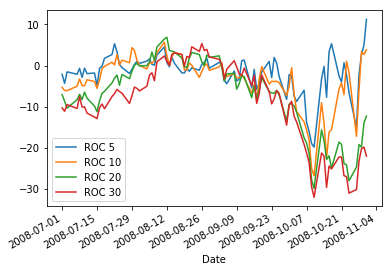

In [9]:
data['2008-07': '2008-10'][['ROC 5', 'ROC 10', 'ROC 20', 'ROC 30']].plot()

# Deviation from zero-lag exponential MA

In [10]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

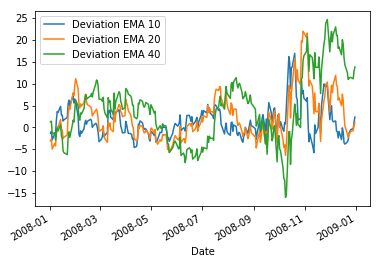

In [11]:
data['2008'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [12]:
for i, j, k in [(14, 20, 12), (12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
#     data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
#     data[f'MACD hist ({i}, {j}, {k})'] = macdhist

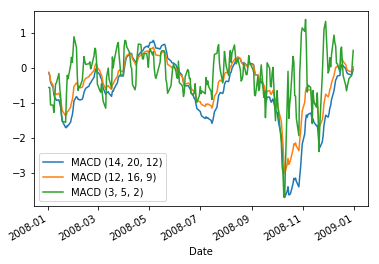

In [13]:
data['2008'][['MACD (14, 20, 12)', 'MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

In [14]:
# data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

In [15]:
# data['2008'][['MACD hist (14, 20, 12)', 'MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [16]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

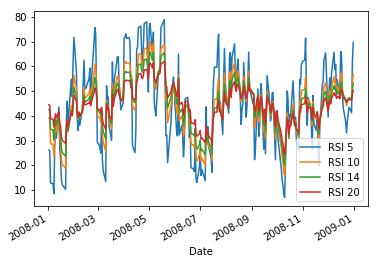

In [17]:
data['2008'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [18]:
for i, j in [(5, 10), (10, 20), (20, 40)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

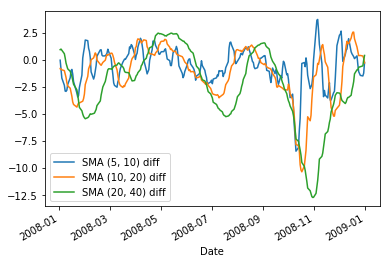

In [19]:
data['2008'][['SMA (5, 10) diff', 'SMA (10, 20) diff', 'SMA (20, 40) diff']].plot()

# ADX

In [20]:
data['ADX 20'] = tl.ADX(high, low, close, timeperiod=20)
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)
data['ADX 7'] = tl.ADX(high, low, close, timeperiod=7)

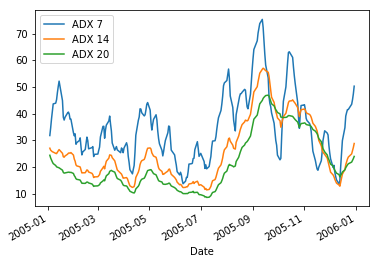

In [21]:
data['2005'][['ADX 7', 'ADX 14', 'ADX 20']].plot()

# CCI

In [22]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

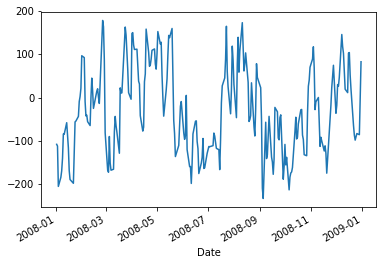

In [23]:
data['2008']['CCI 14'].plot()

# STD deviation 20

In [24]:
data['Std dev 10'] = tl.STDDEV(close, timeperiod=10)
data['Std dev 20'] = tl.STDDEV(close, timeperiod=20)

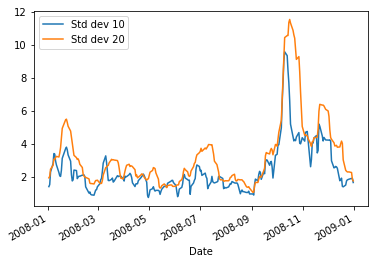

In [25]:
data['2008'][['Std dev 10', 'Std dev 20']].plot()

# Y target value

In [26]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Extreme'] = data['Close'].pct_change(return_day).rolling(return_day).std()*100 # data['Return']

In [27]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 5,ROC 10,ROC 20,ROC 30,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (14, 20, 12)","MACD (12, 16, 9)","MACD (3, 5, 2)",...,"SMA (10, 20) diff","SMA (20, 40) diff",ADX 20,ADX 14,ADX 7,CCI 14,Std dev 10,Std dev 20,Return,Extreme
Date,,,,,,,,,,,,,,,,,,,,,
1999-05-05,-0.415512,-0.046339,1.243877,6.835067,-1.793634,-2.853139,-0.432770,0.403900,0.239577,-0.059121,...,0.93594,2.150785,20.440722,20.489020,27.166137,-11.558144,1.199364,1.942356,-0.359314,0.810993
1999-05-06,-0.267523,-1.595153,-0.637330,5.577426,-1.750246,-3.248888,-1.433450,0.351419,0.192688,-0.138730,...,0.76172,1.987895,19.525417,19.845702,28.433563,-22.992688,1.221660,1.940844,1.271194,1.235761
1999-05-07,1.313321,-0.598251,0.092678,4.247104,-0.453265,-2.032408,-0.610786,0.344498,0.190961,0.027138,...,0.67422,1.884770,18.655876,19.248335,29.519928,-3.573762,1.197413,1.942808,1.296296,1.338307
1999-05-10,-1.001861,-1.658642,-1.455773,4.484667,-0.508662,-2.257764,-1.461731,0.309100,0.161892,-0.034079,...,0.54688,1.661723,17.785037,18.298311,28.103513,-26.438913,1.084316,1.888977,2.244951,1.100919
1999-05-11,1.448598,-1.138434,0.184587,3.454888,0.980149,-0.836615,-0.315329,0.329205,0.186469,0.177762,...,0.37813,1.562503,17.270934,17.280123,24.967837,55.896787,0.789305,1.897725,-1.404919,0.860816


### Features

In [28]:
feature_names = data.drop(['Return', 'Extreme'], axis=1).columns

# Train and test Random Forest

In [29]:
def to_class(y_vec, extreme):
    pos = y_vec > extreme
    neg = y_vec <= -1*extreme

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [30]:
def make_X_y(df):
    X = df.drop(['Return', 'Extreme'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y, df['Extreme']) # extreme_val
    return X, y, ret

In [31]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[-test_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[-test_size:]
    train_ret = ret.iloc[:train_size]
    test_ret = ret.iloc[-test_size:]
    print('Split result before upsampling: {} -> {} + {}'.format(len(X), len(X_train), len(X_test)))
    test_from_date, test_to_date = test_ret.index[0], test_ret.index[-1]
    print(f'Test period: from {test_from_date} to {test_to_date}')
    
    last_q4 = int(train_size/4)
    last_q8 = int(train_size/8)
    last_q16 = int(train_size/16)
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:], X_train[-last_q16:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:], y_train[-last_q16:]], ignore_index=True)
    train_ret = pd.concat([train_ret, train_ret[-last_q4:], train_ret[-last_q8:], train_ret[-last_q16:]], ignore_index=True)
    return X_train, X_test, y_train, y_test, train_ret, test_ret

In [32]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [33]:
def calculate_returns(ret, y_pred, log=True):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    if log:
        print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
        y_pred_s = pd.Series(y_pred, index=ret.index)
        return ret_sum, pd.concat([ret[y_pred == 'Pos'], -1*ret[y_pred == 'Neg']]), y_pred_s
    return ret_sum

In [34]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred, ret):
#     bad_sum     = -8*np.sum(((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos')))
#     np_sum      = -3*np.sum(((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg')))
#     pn_sum      = -1*np.sum(((y_true == 'Pos') & (y_pred == 'Neutral')) | ((y_true == 'Neg') & (y_pred == 'Neutral')))
#     good_sum    =  10*np.sum(((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg')))
#     return bad_sum + np_sum + pn_sum + good_sum
    actual_returns = ret.iloc[y_true.index]
    return calculate_returns(actual_returns, y_pred, log=False) 

In [35]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [36]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, train_ret, test_ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, oob_score=True, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                           ('pca', PCA(svd_solver='auto')), 
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [200],
              'forest__max_depth': [None],
              'forest__max_features': [None],
              'forest__min_samples_split': [2,3,5],
              'forest__min_samples_leaf': [1,3],
              'pca__n_components': [6,12]
             }
    scorer = make_scorer(custom_loss, greater_is_better=True, ret=train_ret)
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring=scorer,
                        cv=5)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum, trades, y_pred_s = calculate_returns(test_ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.index[-1],
        'best_params': best_params,
#         'features': best_estimator.steps[-1][1].feature_importances_,
        'ret_sum': ret_sum,
        'trades': trades,
        'predictions': y_pred_s
    }
    test_params.append(param)

In [37]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 1999-05-05 00:00:00 to 2000-03-07 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-02-23 00:00:00 to 2000-03-07 00:00:00
---
Distribution:
Neutral    143
Neg         74
Pos         70
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.38      1.00      0.55         3
        Pos       1.00      0.40      0.57         5

avg / total       0.61      0.50      0.45        10

---
Confusion matrix
 [[0 2 0]
 [0 3 0]
 [0 3 2]]
5.599840450597204 [long] + 0.0 [short] = 5.599840450597204
From 1999-05-19 00:00:00 to 2000-03-21 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-03-08 00:00:00 to 2000-03-21 00:00:00
---
Distribution:
Neutral    134
Pos         80
Neg         73
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.50      0.75      0.60         4
        Pos       0.75      0.60      0.67         5

avg / total       0.57      0.60      0.57        10

---
Confusion matrix
 [[0 1 0]
 [0 3 1]
 [0 2 3]]
17.476580680417307 [long] + 0.0 [short] = 17.476580680417307
From 1999-06-03 00:00:00 to 2000-04-04 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-03-22 00:00:00 to 2000-04-04 00:00:00
---
Distribution:
Neutral    135
Pos         84
Neg         68
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        2
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.67      0.67      0.67         6
        Pos       0.50      1.00      0.67         2

avg / total       0.50      0.60      0.53        10

---
Confusion matrix
 [[0 2 0]
 [0 4 2]
 [0 0 2]]
1.3555147749211627 [long] + 0.0 [short] = 1.3555147749211627
From 1999-06-17 00:00:00 to 2000-04-18 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-04-05 00:00:00 to 2000-04-18 00:00:00
---
Distribution:
Neutral    135
Pos         85
Neg         67
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    4
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.44      1.00      0.62         4
        Pos       1.00      0.50      0.67         2

avg / total       0.38      0.50      0.38        10

---
Confusion matrix
 [[0 4 0]
 [0 4 0]
 [0 1 1]]
1.1101466275659888 [long] + 0.0 [short] = 1.1101466275659888
From 1999-07-01 00:00:00 to 2000-05-03 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-04-19 00:00:00 to 2000-05-03 00:00:00
---
Distribution:
Neutral    134
Pos         80
Neg         73
Name: Return, dtype: int64
---
Distribution:
Neutral    7
Neg        3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.62      0.71      0.67         7
        Pos       0.00      0.00      0.00         0

avg / total       0.44      0.50      0.47        10

---
Confusion matrix
 [[0 3 0]
 [0 5 2]
 [0 0 0]]
2.2242003972215874 [long] + 0.0 [short] = 2.2242003972215874
From 1999-07-16 00:00:00 to 2000-05-17 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-05-04 00:00:00 to 2000-05-17 00:00:00
---
Distribution:
Neutral    142
Neg         73
Pos         72
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        3
Pos        3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.50      0.50      0.50         4
        Pos       0.33      0.67      0.44         3

avg / total       0.30      0.40      0.33        10

---
Confusion matrix
 [[0 1 2]
 [0 2 2]
 [0 1 2]]
-2.208482662525547 [long] + 0.0 [short] = -2.208482662525547
From 1999-07-30 00:00:00 to 2000-06-01 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-05-18 00:00:00 to 2000-06-01 00:00:00
---
Distribution:
Neutral    141
Pos         76
Neg         70
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    4
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.50      1.00      0.67         4
        Pos       1.00      0.50      0.67         4

avg / total       0.60      0.60      0.53        10

---
Confusion matrix
 [[0 2 0]
 [0 4 0]
 [0 2 2]]
8.903575425582044 [long] + 0.0 [short] = 8.903575425582044
From 1999-08-13 00:00:00 to 2000-06-15 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-06-02 00:00:00 to 2000-06-15 00:00:00
---
Distribution:
Neutral    140
Pos         74
Neg         73
Name: Return, dtype: int64
---
Distribution:
Neutral    7
Pos        2
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.70      1.00      0.82         7
        Pos       0.00      0.00      0.00         2

avg / total       0.49      0.70      0.58        10

---
Confusion matrix
 [[0 1 0]
 [0 7 0]
 [0 2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-08-27 00:00:00 to 2000-06-29 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-06-16 00:00:00 to 2000-06-29 00:00:00
---
Distribution:
Neutral    140
Pos         83
Neg         64
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Neg        4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.38      0.75      0.50         4
    Neutral       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         1

avg / total       0.15      0.30      0.20        10

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.11      1.00      0.20         1
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         6

avg / total       0.01      0.10      0.02        10

---
Confusion matrix
 [[1 0 0]
 [3 0 0]
 [5 1 0]]
0.0 [long] + -6.090409764211701 [short] = -6.090409764211701
From 1999-09-27 00:00:00 to 2000-07-28 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-07-17 00:00:00 to 2000-07-28 00:00:00
---
Distribution:
Neutral    138
Pos         89
Neg         60
Name: Return, dtype: int64
---
Distribution:
Neg        7
Neutral    2
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.29      0.36         7
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         1

avg / total       0.35      0.20      0.25        10

---
Confusion matrix
 [[2 5 0]
 [2 0 0]
 [0 1 0]]
0.0 [long] + 4.992036945961765 [short] = 4.992036945961765
From 1999-10-11 00:00:00 to 2000-08-11 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-07-31 00:00:00 to 2000-08-11 00:00:00
---
Distribution:
Neutral    129
Pos         80
Neg         78
Name: Return, dtype: int64
---
Distribution:
Pos        7
Neg        2
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.00      0.00      0.00         1
        Pos       0.00      0.00      0.00         7

avg / total       0.00      0.00      0.00        10

---
Confusion matrix
 [[0 2 0]
 [1 0 0]
 [1 6 0]]
0.0 [long] + -2.488173312338282 [short] = -2.488173312338282
From 1999-10-25 00:00:00 to 2000-08-25 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-08-14 00:00:00 to 2000-08-25 00:00:00
---
Distribution:
Neutral    111
Pos         95
Neg         81
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.50      0.60      0.55         5
        Pos       0.00      0.00      0.00         4

avg / total       0.25      0.30      0.27        10

---
Confusion matrix
 [[0 1 0]
 [2 3 0]
 [2 2 0]]
0.0 [long] + -2.9972865581076924 [short] = -2.9972865581076924
From 1999-11-08 00:00:00 to 2000-09-11 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-08-28 00:00:00 to 2000-09-11 00:00:00
---
Distribution:
Neutral    113
Pos        100
Neg         74
Name: Return, dtype: int64
---
Distribution:
Neg        5
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         3
        Pos       0.20      1.00      0.33         2

avg / total       0.04      0.20      0.07        10

---
Confusion matrix
 [[0 0 5]
 [0 0 3]
 [0 0 2]]
-4.531694045248769 [long] + 0.0 [short] = -4.531694045248769
From 1999-11-22 00:00:00 to 2000-09-25 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-09-12 00:00:00 to 2000-09-25 00:00:00
---
Distribution:
Neutral    116
Pos         94
Neg         77
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.50      0.33      0.40         6
        Pos       0.00      0.00      0.00         0

avg / total       0.30      0.20      0.24        10

---
Confusion matrix
 [[0 2 2]
 [0 2 4]
 [0 0 0]]
-5.396784430956781 [long] + 0.0 [short] = -5.396784430956781
From 1999-12-07 00:00:00 to 2000-10-09 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-09-26 00:00:00 to 2000-10-09 00:00:00
---
Distribution:
Neutral    122
Neg         88
Pos         77
Name: Return, dtype: int64
---
Distribution:
Neg        5
Neutral    3
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.20      0.29         5
    Neutral       0.40      0.67      0.50         3
        Pos       0.33      0.50      0.40         2

avg / total       0.44

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.67      0.67      0.67         6
        Pos       0.00      0.00      0.00         2

avg / total       0.40      0.40      0.40        10

---
Confusion matrix
 [[0 0 2]
 [0 4 2]
 [0 2 0]]
-1.8829314723803336 [long] + 0.0 [short] = -1.8829314723803336
From 2000-01-20 00:00:00 to 2000-11-20 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-11-07 00:00:00 to 2000-11-20 00:00:00
---
Distribution:
Neutral    133
Neg         79
Pos         75
Name: Return, dtype: int64
---
Distribution:
Neg        5
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.50      0.67      0.57         3
        Pos       0.33      1.00      0.50         2

avg / total       0.22      0.40      0.27        10

---
Confusion matrix
 [[0 2 3]
 [0 2 1]
 [0 0 2]]
-4.703276970178793 [long] + 0.0 [short] = -4.703276970178793
From 2000-02-03 00:00:00 to 2000-12-05 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-11-21 00:00:00 to 2000-12-05 00:00:00
---
Distribution:
Neutral    128
Neg         86
Pos         73
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.83      1.00      0.91         5
        Pos       0.50      0.67      0.57         3

avg / total       0.57      0.70      0.63        10

---
Confusion matrix
 [[0 0 2]
 [0 5 0]
 [0 1 2]]
-0.1912349155043458 [long] + 0.0 [short] = -0.1912349155043458
From 2000-02-17 00:00:00 to 2000-12-19 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2000-12-06 00:00:00 to 2000-12-19 00:00:00
---
Distribution:
Neutral    123
Neg         88
Pos         76
Name: Return, dtype: int64
---
Distribution:
Neg        5
Neutral    3
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.67      0.40      0.50         5
    Neutral       0.25      0.33      0.29         3
        Pos       0.00      0.00      0.00         2

avg / total       0.

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.50      0.75      0.60         4
        Pos       0.00      0.00      0.00         6

avg / total       0.20      0.30      0.24        10

---
Confusion matrix
 [[0 0 0]
 [1 3 0]
 [3 3 0]]
0.0 [long] + -6.499679188371421 [short] = -6.499679188371421
From 2000-03-31 00:00:00 to 2001-02-02 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-01-22 00:00:00 to 2001-02-02 00:00:00
---
Distribution:
Neutral    131
Neg         83
Pos         73
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        3
Pos        3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.29      0.67      0.40         3
    Neutral       0.33      0.25      0.29         4
        Pos       0.00      0.00      0.00         3

avg / total       0.22      0.30      0.23        10

---
Confusion matrix
 [[2 1 0]
 [3 1 0]
 [2 1 0]]
0.0 [long] + 0.001785079212179852 [short] = 0.001785079212179852
From 2000-04-14 00:00:00 to 2001-02-16 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-02-05 00:00:00 to 2001-02-16 00:00:00
---
Distribution:
Neutral    125
Pos         90
Neg         72
Name: Return, dtype: int64
---
Distribution:
Neg        7
Neutral    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      0.57      0.67         7
    Neutral       0.40      0.67      0.50         3

avg / total       0.68      0.60      0.62        10

---
Confusion matrix
 [[4 3]
 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.67      0.67      0.67         6
        Pos       0.50      1.00      0.67         2

avg / total       0.50      0.60      0.53        10

---
Confusion matrix
 [[0 2 0]
 [0 4 2]
 [0 0 2]]
6.459439950447687 [long] + 0.0 [short] = 6.459439950447687
From 2000-05-15 00:00:00 to 2001-03-19 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-03-06 00:00:00 to 2001-03-19 00:00:00
---
Distribution:
Neutral    124
Neg         97
Pos         66
Name: Return, dtype: int64
---
Distribution:
Neg        8
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.25      0.40         8
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         0

avg / total       0.80      0.20      0.32        10

---
Confusion matrix
 [[2 3 3]
 [0 0 2]
 [0 0 0]]
-10.116319713552802 [long] + 10.214002680555934 [short] = 0.0976829670031325
From 2000-05-30 00:00:00 to 2001-04-02 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-03-20 00:00:00 to 2001-04-02 00:00:00
---
Distribution:
Neutral    119
Neg        100
Pos         68
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.25      0.50      0.33         2
    Neutral       0.25      0.20      0.22         5
        Pos       0.50      0.33      0.40         3

avg / 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.33      1.00      0.50         3
        Pos       0.00      0.00      0.00         7

avg / total       0.10      0.30      0.15        10

---
Confusion matrix
 [[0 0 0]
 [0 3 0]
 [1 6 0]]
0.0 [long] + -6.845238095238115 [short] = -6.845238095238115
From 2000-06-27 00:00:00 to 2001-05-01 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-04-18 00:00:00 to 2001-05-01 00:00:00
---
Distribution:
Neutral    115
Neg         95
Pos         77
Name: Return, dtype: int64
---
Distribution:
Neutral    7
Pos        2
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.50      0.14      0.22         7
        Pos       0.00      0.00      0.00         2

avg / total       0.35      0.10      0.16        10

---
Confusion matrix
 [[0 1 0]
 [6 1 0]
 [2 0 0]]
0.0 [long] + -9.032319219528627 [short] = -9.032319219528627
From 2000-07-12 00:00:00 to 2001-05-15 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-05-02 00:00:00 to 2001-05-15 00:00:00
---
Distribution:
Neutral    116
Pos         86
Neg         85
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.25      0.50      0.33         2
    Neutral       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         3

avg / total       0.05      0.10      0.07        10

---
Confusion matrix
 [[1 0 1]
 [0 0 5]
 [3 0 0]]
-1.4147758561024792 [long] + -8.195093541724063 [short] = -9.609869397826543
From 2000-07-26 00:00:00 to 2001-05-30 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-05-16 00:00:00 to 2001-05-30 00:00:00
---
Distribution:
Neutral    131
Neg         79
Pos         77
Name: Return, dtype: int64
---
Distribution:
Neg        6
Pos        3
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.62      0.83      0.71         6
    Neutral       0.00      0.00      0.00         1
        Pos       0.00      0.00      0.00         3

avg / total       0.38      0.50      0.43        10

---
Confusion matrix
 [[5 1 0]
 [1 0 0]
 [2 1 0]]
0.0 [long] + 6.023459377282058 [short] = 6.023459377282058
From 2000-08-09 00:00:00 to 2001-06-13 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-05-31 00:00:00 to 2001-06-13 00:00:00
---
Distribution:
Neutral    118
Neg         87
Pos         82
Name: Return, dtype: int64
---
Distribution:
Neg        7
Neutral    2
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.70      1.00      0.82         7
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         1

avg / total       0.49      0.70      0.58        10

---
Confusion matrix
 [[7 0 0]
 [2 0 0]
 [1 0 0]]
0.0 [long] + 11.7779427606308 [short] = 11.7779427606308
From 2000-08-23 00:00:00 to 2001-06-27 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-06-14 00:00:00 to 2001-06-27 00:00:00
---
Distribution:
Neutral    111
Neg        101
Pos         75
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        2
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         2
    Neutral       0.75      1.00      0.86         6
        Pos       0.00      0.00      0.00         2

avg / total       0.65      0.80      0.71        10

---
Confusion matrix
 [[2 0 0]
 [0 6 0]
 [0 2 0]]
0.0 [long] + 2.9484875277154265 [short] = 2.9484875277154265
From 2000-09-07 00:00:00 to 2001-07-12 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-06-28 00:00:00 to 2001-07-12 00:00:00
---
Distribution:
Neutral    114
Neg        108
Pos         65
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        3
Pos        3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      0.67      0.50         3
    Neutral       0.50      0.50      0.50         4
        Pos       0.00      0.00      0.00         3

avg / total       0.32

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      1.00      0.50         3
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         3

avg / total       0.10      0.30      0.15        10

---
Confusion matrix
 [[3 0 0]
 [4 0 0]
 [2 1 0]]
0.0 [long] + 3.859079896981699 [short] = 3.859079896981699
From 2000-10-05 00:00:00 to 2001-08-09 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-07-27 00:00:00 to 2001-08-09 00:00:00
---
Distribution:
Neutral    116
Neg         98
Pos         73
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Neg        4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.67      0.50      0.57         4
    Neutral       0.50      0.40      0.44         5
        Pos       0.33      1.00      0.50         1

avg / total       0.55  

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         8
    Neutral       0.29      1.00      0.44         2
        Pos       0.00      0.00      0.00         0

avg / total       0.06      0.20      0.09        10

---
Confusion matrix
 [[0 5 3]
 [0 2 0]
 [0 0 0]]
-12.945837833438521 [long] + 0.0 [short] = -12.945837833438521
From 2000-11-16 00:00:00 to 2001-09-27 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-09-10 00:00:00 to 2001-09-27 00:00:00
---
Distribution:
Neutral    124
Neg        105
Pos         58
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        3
Pos        3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.50      0.75      0.60         4
        Pos       0.25      0.33      0.29         3

avg / total       0.28      0.40      0.33        10

---
Confusion matrix
 [[0 1 2]
 [0 3 1]
 [0 2 1]]
-10.012389778375164 [long] + 0.0 [short] = -10.012389778375164
From 2000-12-01 00:00:00 to 2001-10-11 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-09-28 00:00:00 to 2001-10-11 00:00:00
---
Distribution:
Neg        114
Neutral    112
Pos         61
Name: Return, dtype: int64
---
Distribution:
Pos        6
Neg        2
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.00      0.00      0.00         2
        Pos       0.33      0.17      0.22         6

avg / total       0.20      0.10      0.13        10

---
Confusion matrix
 [[0 2 0]
 [0 0 2]
 [0 5 1]]
4.236519178715703 [long] + 0.0 [short] = 4.236519178715703
From 2000-12-15 00:00:00 to 2001-10-25 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-10-12 00:00:00 to 2001-10-25 00:00:00
---
Distribution:
Neutral    107
Neg        103
Pos         77
Name: Return, dtype: int64
---
Distribution:
Neg        5
Pos        3
Neutral    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
    Neutral       0.50      1.00      0.67         2
        Pos       0.40      0.67      0.50         3

avg / total       0.72  

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.10      1.00      0.18         1
    Neutral       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         4

avg / total       0.01      0.10      0.02        10

---
Confusion matrix
 [[1 0 0]
 [5 0 0]
 [4 0 0]]
0.0 [long] + -4.820199778155775 [short] = -4.820199778155775
From 2001-01-31 00:00:00 to 2001-12-07 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-11-26 00:00:00 to 2001-12-07 00:00:00
---
Distribution:
Neutral    119
Neg         89
Pos         79
Name: Return, dtype: int64
---
Distribution:
Neg        5
Pos        3
Neutral    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.20      0.25         5
    Neutral       0.00      0.00      0.00         2
        Pos       0.33      0.33      0.33         3

avg / total       0.27

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         8
        Pos       0.40      1.00      0.57         2

avg / total       0.08      0.20      0.11        10

---
Confusion matrix
 [[0 0 0]
 [5 0 3]
 [0 0 2]]
2.0526373536067455 [long] + -0.9495831361915341 [short] = 1.1030542174152114
From 2001-03-01 00:00:00 to 2002-01-08 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2001-12-24 00:00:00 to 2002-01-08 00:00:00
---
Distribution:
Neutral    116
Neg         87
Pos         84
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    4
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         2
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07        10

---
Confusion matrix
 [[2 0 0]
 [4 0 0]
 [4 0 0]]
0.0 [long] + -0.4701255438574803 [short] = -0.4701255438574803
From 2001-03-15 00:00:00 to 2002-01-23 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-01-09 00:00:00 to 2002-01-23 00:00:00
---
Distribution:
Neutral    122
Pos         88
Neg         77
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Neg        4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.00      0.00      0.00         5
        Pos       0.10      1.00      0.18         1

avg / total       0.01      0.10      0.02        10

---
Confusion matrix
 [[0 0 4]
 [0 0 5]
 [0 0 1]]
-4.831559604310465 [long] + 0.0 [short] = -4.831559604310465
From 2001-03-29 00:00:00 to 2002-02-06 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-01-24 00:00:00 to 2002-02-06 00:00:00
---
Distribution:
Neutral    123
Neg         87
Pos         77
Name: Return, dtype: int64
---
Distribution:
Neg        6
Neutral    3
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.67      0.67      0.67         6
    Neutral       0.00      0.00      0.00         3
        Pos       0.50      1.00      0.67         1

avg / total       0.45

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.38      1.00      0.55         3
    Neutral       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         2

avg / total       0.61      0.50      0.45        10

---
Confusion matrix
 [[3 0 0]
 [3 2 0]
 [2 0 0]]
0.0 [long] + 0.08159026805287795 [short] = 0.08159026805287795
From 2001-04-27 00:00:00 to 2002-03-07 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-02-22 00:00:00 to 2002-03-07 00:00:00
---
Distribution:
Neutral    119
Neg        105
Pos         63
Name: Return, dtype: int64
---
Distribution:
Pos        6
Neutral    4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.25      0.25      0.25         4
        Pos       0.00      0.00      0.00         6

avg / total       0.10      0.10      0.10        10

---
Confusion matrix
 [[0 0 0]
 [3 1 0]
 [3 3 0]]
0.0 [long] + -10.403416274644584 [short] = -10.403416274644584
From 2001-05-11 00:00:00 to 2002-03-21 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-03-08 00:00:00 to 2002-03-21 00:00:00
---
Distribution:
Neutral    113
Neg         92
Pos         82
Name: Return, dtype: int64
---
Distribution:
Neg        5
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.25      0.20      0.22         5
    Neutral       0.00      0.00      0.00         4
        Pos       0.17      1.00      0.29         1

avg / total       0.14      0.20      0.14        10

---
Confusion matrix
 [[1 0 4]
 [3 0 1]
 [0 0 1]]
-5.387819509646707 [long] + 1.9150671090729765 [short] = -3.472752400573731
From 2001-05-25 00:00:00 to 2002-04-05 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-03-22 00:00:00 to 2002-04-05 00:00:00
---
Distribution:
Neutral    121
Neg         92
Pos         74
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    4
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.25      0.40         4
    Neutral       0.50      0.25      0.33         4
        Pos       0.29      1.00      0.44         2

avg / t

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.57      0.80      0.67         5
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.29      0.40      0.33        10

---
Confusion matrix
 [[4 1 0]
 [2 0 0]
 [1 2 0]]
0.0 [long] + 10.019780410550872 [short] = 10.019780410550872
From 2001-06-25 00:00:00 to 2002-05-03 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-04-22 00:00:00 to 2002-05-03 00:00:00
---
Distribution:
Neutral    112
Neg         96
Pos         79
Name: Return, dtype: int64
---
Distribution:
Neg        5
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.14      0.50      0.22         2
        Pos       0.67      0.67      0.67         3

avg / total       0.23      0.30      0.24        10

---
Confusion matrix
 [[0 5 0]
 [0 1 1]
 [0 1 2]]
3.185253417408329 [long] + 0.0 [short] = 3.185253417408329
From 2001-07-10 00:00:00 to 2002-05-17 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-05-06 00:00:00 to 2002-05-17 00:00:00
---
Distribution:
Neutral    108
Neg        101
Pos         78
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        2
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.67      0.33      0.44         6
        Pos       0.20      0.50      0.29         2

avg / total       0.44  

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.14      0.25         7
    Neutral       0.50      0.67      0.57         3
        Pos       0.00      0.00      0.00         0

avg / total       0.85      0.30      0.35        10

---
Confusion matrix
 [[1 2 4]
 [0 2 1]
 [0 0 0]]
-7.929466648276695 [long] + 2.2149532710280417 [short] = -5.714513377248654
From 2001-08-07 00:00:00 to 2002-06-17 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-06-04 00:00:00 to 2002-06-17 00:00:00
---
Distribution:
Neutral    113
Neg        107
Pos         67
Name: Return, dtype: int64
---
Distribution:
Neg    7
Pos    3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.29      0.44         7
    Neutral       0.00      0.00      0.00         0
        Pos       0.50      1.00      0.67         3

avg / total       0.85      0.50      0.51        10

---
Confusion matrix
 [[2 2 3]
 [0 0 0]
 [0 0 3]]
2.080405074774705 [long] + 2.1852721087455618 [short] = 4.265677183520267
From 2001-08-21 00:00:00 to 2002-07-01 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-06-18 00:00:00 to 2002-07-01 00:00:00
---
Distribution:
Neg        125
Neutral     96
Pos         66
Name: Return, dtype: int64
---
Distribution:
Neg        5
Neutral    3
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      0.40      0.40         5
    Neutral       0.33      0.33      0.33         3
        Pos       0.00      0.00      0.00         2

avg / tot

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
    Neutral       0.44      1.00      0.62         4
        Pos       0.00      0.00      0.00         1

avg / total       0.68      0.50      0.41        10

---
Confusion matrix
 [[1 4 0]
 [0 4 0]
 [0 1 0]]
0.0 [long] + 5.302335066789022 [short] = 5.302335066789022
From 2001-09-25 00:00:00 to 2002-07-30 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-07-17 00:00:00 to 2002-07-30 00:00:00
---
Distribution:
Neg        116
Neutral     99
Pos         72
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neg        3
Neutral    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.33      0.33         3
    Neutral       0.00      0.00      0.00         3
        Pos       0.17      0.25      0.20         4

avg / total       0.17  

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.14      1.00      0.25         1
    Neutral       0.33      0.20      0.25         5
        Pos       0.00      0.00      0.00         4

avg / total       0.18      0.20      0.15        10

---
Confusion matrix
 [[1 0 0]
 [4 1 0]
 [2 2 0]]
0.0 [long] + 1.0145395797156906 [short] = 1.0145395797156906
From 2001-10-23 00:00:00 to 2002-08-27 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-08-14 00:00:00 to 2002-08-27 00:00:00
---
Distribution:
Neg        108
Neutral    106
Pos         73
Name: Return, dtype: int64
---
Distribution:
Neg        4
Pos        3
Neutral    3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.43      1.00      0.60         3
        Pos       0.00      0.00      0.00         3

avg / total       0.13      0.30      0.18        10

---
Confusion matrix
 [[0 1 3]
 [0 3 0]
 [0 3 0]]
-8.445565398680321 [long] + 0.0 [short] = -8.445565398680321
From 2001-11-06 00:00:00 to 2002-09-11 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-08-28 00:00:00 to 2002-09-11 00:00:00
---
Distribution:
Neutral    112
Neg         91
Pos         84
Name: Return, dtype: int64
---
Distribution:
Neg        5
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.71      1.00      0.83         5
    Neutral       0.00      0.00      0.00         2
        Pos       0.67      0.67      0.67         3

avg / total       0.56      0.70      0.62        10

---
Confusion matrix
 [[5 0 0]
 [1 0 1]
 [1 0 2]]
5.795422230628766 [long] + 13.198889254506406 [short] = 18.99431148513517
From 2001-11-20 00:00:00 to 2002-09-25 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-09-12 00:00:00 to 2002-09-25 00:00:00
---
Distribution:
Neg        109
Neutral     97
Pos         81
Name: Return, dtype: int64
---
Distribution:
Neg        6
Neutral    3
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      0.67      0.73         6
    Neutral       0.40      0.67      0.50         3
        Pos       0.00      0.00      0.00         1

avg / total       0.60      0.60      0.59        10

---
Confusion matrix
 [[4 2 0]
 [1 2 0]
 [0 1 0]]
0.0 [long] + 18.36411904840279 [short] = 18.36411904840279
From 2001-12-05 00:00:00 to 2002-10-09 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-09-26 00:00:00 to 2002-10-09 00:00:00
---
Distribution:
Neg        122
Neutral     98
Pos         67
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Neg        3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      1.00      0.67         3
    Neutral       0.75      0.60      0.67         5
        Pos       0.00      0.00      0.00         2

avg / total       0.53      0.60      0.53        10

---
Confusion matrix
 [[3 0 0]
 [2 3 0]
 [1 1 0]]
0.0 [long] + 11.217959525026 [short] = 11.217959525026
From 2001-12-19 00:00:00 to 2002-10-23 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-10-10 00:00:00 to 2002-10-23 00:00:00
---
Distribution:
Neg        119
Neutral    105
Pos         63
Name: Return, dtype: int64
---
Distribution:
Neutral    7
Pos        3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.75      0.86      0.80         7
        Pos       0.00      0.00      0.00         3

avg / total       0.53      0.60      0.56        10

---
Confusion matrix
 [[0 0 0]
 [1 6 0]
 [1 2 0]]
0.0 [long] + -5.5986631008518195 [short] = -5.5986631008518195
From 2002-01-04 00:00:00 to 2002-11-06 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-10-24 00:00:00 to 2002-11-06 00:00:00
---
Distribution:
Neg        108
Neutral    107
Pos         72
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    4
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.29      1.00      0.44         2
    Neutral       1.00      0.75      0.86         4
        Pos       0.00      0.00      0.00         4

avg / total       0.46      0.50      0.43        10

---
Confusion matrix
 [[2 0 0]
 [1 3 0]
 [4 0 0]]
0.0 [long] + -2.7119494797275827 [short] = -2.7119494797275827
From 2002-01-18 00:00:00 to 2002-11-20 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-11-07 00:00:00 to 2002-11-20 00:00:00
---
Distribution:
Neutral    114
Neg         96
Pos         77
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5
        Pos       0.40      0.40      0.40         5

avg / total       0.20      0.20      0.20        10

---
Confusion matrix
 [[0 0 0]
 [2 0 3]
 [0 3 2]]
4.4946729957785365 [long] + -0.6534657739642014 [short] = 3.841207221814335
From 2002-02-04 00:00:00 to 2002-12-05 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2002-11-21 00:00:00 to 2002-12-05 00:00:00
---
Distribution:
Neutral    122
Neg         89
Pos         76
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        4
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.50      0.67         4
    Neutral       0.75      1.00      0.86         6

avg / total       0.85      0.80      0.78        10

---
Confusion matri

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      1.00      0.67         3
    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         3

avg / total       0.45      0.60      0.50        10

---
Confusion matrix
 [[3 0 0]
 [1 3 0]
 [2 1 0]]
0.0 [long] + -2.7422671323985233 [short] = -2.7422671323985233
From 2002-03-19 00:00:00 to 2003-01-21 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-01-07 00:00:00 to 2003-01-21 00:00:00
---
Distribution:
Neutral    117
Neg        101
Pos         69
Name: Return, dtype: int64
---
Distribution:
Neg        7
Neutral    3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.43      0.60         7
    Neutral       0.50      1.00      0.67         3
        Pos       0.00      0.00      0.00         0

avg / total       0.85      0.60      0.62        10

---
Confusion matrix
 [[3 3 1]
 [0 3 0]
 [0 0 0]]
-3.2156862745098103 [long] + 9.710766759778565 [short] = 6.495080485268755
From 2002-04-03 00:00:00 to 2003-02-04 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-01-22 00:00:00 to 2003-02-04 00:00:00
---
Distribution:
Neutral    122
Neg        103
Pos         62
Name: Return, dtype: int64
---
Distribution:
Neg        6
Neutral    3
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.50      0.67         6
    Neutral       0.00      0.00      0.00         3
        Pos       0.14      1.00      0.25         1

avg / total       0.61      0.40      0.42        10

---
Confusion matrix
 [[3 0 3]
 [0 0 3]
 [0 0 1]]
-6.331643888394001 [long] + 5.76586218177495 [short] = -0.5657817066190507
From 2002-04-17 00:00:00 to 2003-02-19 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-02-05 00:00:00 to 2003-02-19 00:00:00
---
Distribution:
Neg        117
Neutral    112
Pos         58
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.50      0.50         2
    Neutral       1.00      0.60      0.75         5
        Pos       0.60      1.00      0.75         3

avg / to

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.40      0.36         5
    Neutral       0.50      0.20      0.29         5
        Pos       0.00      0.00      0.00         0

avg / total       0.42      0.30      0.32        10

---
Confusion matrix
 [[2 1 2]
 [4 1 0]
 [0 0 0]]
-3.301422378093144 [long] + 1.5742397560116195 [short] = -1.7271826220815245
From 2002-05-15 00:00:00 to 2003-03-19 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-03-06 00:00:00 to 2003-03-19 00:00:00
---
Distribution:
Neutral    120
Neg        111
Pos         56
Name: Return, dtype: int64
---
Distribution:
Pos        6
Neg        2
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.33      1.00      0.50         2
        Pos       0.00      0.00      0.00         6

avg / total       0.07      0.20      0.10        10

---
Confusion matrix
 [[0 2 0]
 [0 2 0]
 [4 2 0]]
0.0 [long] + -18.753472642084024 [short] = -18.753472642084024
From 2002-05-30 00:00:00 to 2003-04-02 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-03-20 00:00:00 to 2003-04-02 00:00:00
---
Distribution:
Neg        113
Neutral    104
Pos         70
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        2
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      0.50      0.55         6
        Pos       0.40      1.00      0.57         2

avg / total       0.44      0.50      0.44        10

---
Confusion matrix
 [[0 2 0]
 [0 3 3]
 [0 0 2]]
6.33332534604193 [long] + 0.0 [short] = 6.33332534604193
From 2002-06-13 00:00:00 to 2003-04-16 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-04-03 00:00:00 to 2003-04-16 00:00:00
---
Distribution:
Neutral    121
Neg         99
Pos         67
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.56      1.00      0.71         5
        Pos       0.00      0.00      0.00         4

avg / total       0.28      0.50      0.36        10

---
Confusion matrix
 [[0 1 0]
 [0 5 0]
 [1 3 0]]
0.0 [long] + -1.2621916236374098 [short] = -1.2621916236374098
From 2002-06-27 00:00:00 to 2003-05-01 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-04-17 00:00:00 to 2003-05-01 00:00:00
---
Distribution:
Neutral    122
Neg         85
Pos         80
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.43      0.60      0.50         5
        Pos       0.50      0.20      0.29         5

avg / total       0.46      0.40      0.39        10

---
Confusion matrix
 [[0 0 0]
 [1 3 1]
 [0 4 1]]
0.6921779721176691 [long] + 0.42308526795400425 [short] = 1.1152632400716733
From 2002-07-12 00:00:00 to 2003-05-15 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-05-02 00:00:00 to 2003-05-15 00:00:00
---
Distribution:
Neutral    136
Pos         78
Neg         73
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.50      1.00      0.67         5
        Pos       0.00      0.00      0.00         3

avg / total       0.25      0.50      0.33        10

---
Confusion matrix
 [[0 2 0]
 [0 5 0]
 [0 3 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-07-26 00:00:00 to 2003-05-30 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-05-16 00:00:00 to 2003-05-30 00:00:00
---
Distribution:
Neutral    131
Pos         92
Neg         64
Name: Return, dtype: int64
---
Distribution:
Pos        6
Neutral    3
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.14      0.33      0.20         3
        Pos       0.33      0.17      0.22         6

avg / total       0.24      0.20      0.19        10

---
Confusion matrix
 [[0 1 0]
 [0 1 2]
 [0 5 1]]
5.367157501868625 [long] + 0.0 [short] = 5.367157501868625
From 2002-08-09 00:00:00 to 2003-06-13 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-06-02 00:00:00 to 2003-06-13 00:00:00
---
Distribution:
Neutral    132
Pos         85
Neg         70
Name: Return, dtype: int64
---
Distribution:
Pos        6
Neg        2
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.17      0.50      0.25         2
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         6

avg / total       0.03      0.10      0.05        10

---
Confusion matrix
 [[1 1 0]
 [2 0 0]
 [3 3 0]]
0.0 [long] + -6.731422398050235 [short] = -6.731422398050235
From 2002-08-23 00:00:00 to 2003-06-27 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-06-16 00:00:00 to 2003-06-27 00:00:00
---
Distribution:
Neutral    114
Pos        101
Neg         72
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Neg        4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.25      0.40         4
    Neutral       0.56      1.00      0.71         5
        Pos       0.00      0.00      0.00         1

avg / total       0.68      0.60      0.52        10

---
Confusion matrix
 [[1 3 0]
 [0 5 0]
 [0 1 0]]
0.0 [long] + 0.8729192042224887 [short] = 0.8729192042224887
From 2002-09-09 00:00:00 to 2003-07-14 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-06-30 00:00:00 to 2003-07-14 00:00:00
---
Distribution:
Neutral    120
Pos         91
Neg         76
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neg        3
Neutral    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.50      0.67      0.57         3
        Pos       0.60      0.75      0.67         4

avg / total       0.39

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.29      0.67      0.40         3
    Neutral       0.67      0.33      0.44         6
        Pos       0.00      0.00      0.00         1

avg / total       0.49      0.40      0.39        10

---
Confusion matrix
 [[2 1 0]
 [4 2 0]
 [1 0 0]]
0.0 [long] + -1.0771684797234116 [short] = -1.0771684797234116
From 2002-10-07 00:00:00 to 2003-08-11 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-07-29 00:00:00 to 2003-08-11 00:00:00
---
Distribution:
Neutral    134
Pos         81
Neg         72
Name: Return, dtype: int64
---
Distribution:
Neg        4
Pos        3
Neutral    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.75      0.86         4
    Neutral       0.50      1.00      0.67         3
        Pos       1.00      0.33      0.50         3

avg / total       0.

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.30      1.00      0.46         3
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         4

avg / total       0.09      0.30      0.14        10

---
Confusion matrix
 [[3 0 0]
 [3 0 0]
 [4 0 0]]
0.0 [long] + -3.042556950044617 [short] = -3.042556950044617
From 2002-11-04 00:00:00 to 2003-09-09 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-08-26 00:00:00 to 2003-09-09 00:00:00
---
Distribution:
Neutral    119
Neg         84
Pos         84
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neg        3
Neutral    3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.22      0.67      0.33         3
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         4

avg / total       0.07      0.20      0.10        10

---
Confusion matrix
 [[2 1 0]
 [3 0 0]
 [4 0 0]]
0.0 [long] + -6.23388856538084 [short] = -6.23388856538084
From 2002-11-18 00:00:00 to 2003-09-23 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-09-10 00:00:00 to 2003-09-23 00:00:00
---
Distribution:
Neutral    111
Pos         93
Neg         83
Name: Return, dtype: int64
---
Distribution:
Neg        5
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.33      0.50      0.40         2
        Pos       0.29      0.67      0.40         3

avg / total       0.15      0.30      0.20        10

---
Confusion matrix
 [[0 1 4]
 [0 1 1]
 [0 1 2]]
-4.0547561074470995 [long] + 0.0 [short] = -4.0547561074470995
From 2002-12-03 00:00:00 to 2003-10-07 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-09-24 00:00:00 to 2003-10-07 00:00:00
---
Distribution:
Neutral    110
Neg         89
Pos         88
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.67      0.40      0.50         5
        Pos       0.57      0.80      0.67         5

avg / total       0.62      0.60      0.58        10

---
Confusion matrix
 [[2 3]
 [1

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         6
        Pos       0.60      0.75      0.67         4

avg / total       0.24      0.30      0.27        10

---
Confusion matrix
 [[0 0 0]
 [4 0 2]
 [0 1 3]]
4.6783021405662595 [long] + -0.9304008444518508 [short] = 3.7479012961144087
From 2003-01-16 00:00:00 to 2003-11-18 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-11-05 00:00:00 to 2003-11-18 00:00:00
---
Distribution:
Pos        107
Neutral    105
Neg         75
Name: Return, dtype: int64
---
Distribution:
Neg        5
Neutral    3
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
    Neutral       0.50      0.33      0.40         3
        Pos       0.17      0.50      0.25         2

avg / 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.40      0.50      0.44         4
        Pos       0.40      0.40      0.40         5

avg / total       0.36      0.40      0.38        10

---
Confusion matrix
 [[0 0 1]
 [0 2 2]
 [0 3 2]]
1.6057835111931151 [long] + 0.0 [short] = 1.6057835111931151
From 2003-03-03 00:00:00 to 2004-01-02 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2003-12-18 00:00:00 to 2004-01-02 00:00:00
---
Distribution:
Neutral    121
Pos        100
Neg         66
Name: Return, dtype: int64
---
Distribution:
Pos        6
Neutral    4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         6

avg / total       0.00      0.00      0.00        10

---
Confusion matrix
 [[0 0 0]
 [1 0 3]
 [4 2 0]]
0.679024805798667 [long] + -5.1690983350290765 [short] = -4.4900735292304095
From 2003-03-17 00:00:00 to 2004-01-16 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-01-05 00:00:00 to 2004-01-16 00:00:00
---
Distribution:
Neutral    123
Pos        109
Neg         55
Name: Return, dtype: int64
---
Distribution:
Pos        7
Neutral    2
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.12      1.00      0.22         1
    Neutral       0.00      0.00      0.00         2
        Pos       1.00      0.14      0.25         7

avg / 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.00      0.00      0.00         6
        Pos       0.10      1.00      0.18         1

avg / total       0.01      0.10      0.02        10

---
Confusion matrix
 [[0 0 3]
 [0 0 6]
 [0 0 1]]
-3.7243121358692344 [long] + 0.0 [short] = -3.7243121358692344
From 2003-04-14 00:00:00 to 2004-02-17 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-02-03 00:00:00 to 2004-02-17 00:00:00
---
Distribution:
Pos        121
Neutral    107
Neg         59
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      1.00      0.50         1
    Neutral       1.00      0.60      0.75         5
        Pos       0.75      0.75      0.75         4

avg / total       0.

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         4
        Pos       0.20      1.00      0.33         1

avg / total       0.02      0.10      0.03        10

---
Confusion matrix
 [[0 5 0]
 [0 0 4]
 [0 0 1]]
0.8412357035718743 [long] + 0.0 [short] = 0.8412357035718743
From 2003-05-28 00:00:00 to 2004-03-30 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-03-17 00:00:00 to 2004-03-30 00:00:00
---
Distribution:
Neutral    108
Pos        104
Neg         75
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.25      1.00      0.40         2
        Pos       0.00      0.00      0.00         5

avg / total       0.05      0.20      0.08        10

---
Confusion matrix
 [[0 3 0]
 [0 2 0]
 [2 3 0]]
0.0 [long] + -2.4912461366148886 [short] = -2.4912461366148886
From 2003-06-11 00:00:00 to 2004-04-14 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-03-31 00:00:00 to 2004-04-14 00:00:00
---
Distribution:
Neutral    116
Pos         95
Neg         76
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Neg        3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.50      1.00      0.67         5
        Pos       0.00      0.00      0.00         2

avg / total       0.25      0.50      0.33        10

---
Confusion matrix
 [[0 3 0]
 [0 5 0]
 [0 2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-06-25 00:00:00 to 2004-04-28 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-04-15 00:00:00 to 2004-04-28 00:00:00
---
Distribution:
Neutral    111
Pos        104
Neg         72
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Neg        3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.67      0.57         3
    Neutral       0.00      0.00      0.00         5
        Pos       0.33      1.00      0.50         2

avg / total       0.22      0.40      0.27        10

---
Confusion matrix
 [[2 0 1]
 [2 0 3]
 [0 0 2]]
1.967979362773653 [long] + 6.921298495007366 [short] = 8.88927785778102
From 2003-07-10 00:00:00 to 2004-05-12 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-04-29 00:00:00 to 2004-05-12 00:00:00
---
Distribution:
Neutral    119
Pos         96
Neg         72
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        3
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.67      0.33      0.44         6
        Pos       0.00      0.00      0.00         1

avg / total       0.40      0.20      0.27        10

---
Confusion matrix
 [[0 0 3]
 [0 2 4]
 [0 1 0]]
-8.060188119649382 [long] + 0.0 [short] = -8.060188119649382
From 2003-07-24 00:00:00 to 2004-05-26 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-05-13 00:00:00 to 2004-05-26 00:00:00
---
Distribution:
Neutral    115
Pos         89
Neg         83
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       1.00      0.20      0.33         5
        Pos       0.44      1.00      0.62         4

avg / total       0.68      0.50      0.41        10

---
Confusion matrix
 [[0 0 1]
 [0 1 4]
 [0 0 4]]
7.551955157163525 [long] + 0.0 [short] = 7.551955157163525
From 2003-08-07 00:00:00 to 2004-06-10 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-05-27 00:00:00 to 2004-06-10 00:00:00
---
Distribution:
Neutral    124
Pos         95
Neg         68
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.14      1.00      0.25         1
    Neutral       0.00      0.00      0.00         5
        Pos       1.00      0.25      0.40         4

avg / total       0.41  

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.60      1.00      0.75         6

avg / total       0.36      0.60      0.45        10

---
Confusion matrix
 [[0 4]
 [0 6]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-09-19 00:00:00 to 2004-07-26 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-07-13 00:00:00 to 2004-07-26 00:00:00
---
Distribution:
Neutral    135
Pos         88
Neg         64
Name: Return, dtype: int64
---
Distribution:
Neg        5
Neutral    3
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
    Neutral       0.40      0.67      0.50         3
        Pos       0.00      0.00      0.00         2

avg / total       0.62      0.40      0.44        10

---
Confusion matrix
 [[2 1 2]
 [0 2 1]
 [0 2 0]]
-4.20528283872

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.25      0.29         4
    Neutral       1.00      0.33      0.50         6
        Pos       0.00      0.00      0.00         0

avg / total       0.73      0.30      0.41        10

---
Confusion matrix
 [[1 0 3]
 [2 2 2]
 [0 0 0]]
-7.3406301684498025 [long] + -0.041186077244381725 [short] = -7.381816245694184
From 2003-10-17 00:00:00 to 2004-08-23 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-08-10 00:00:00 to 2004-08-23 00:00:00
---
Distribution:
Neutral    132
Neg         81
Pos         74
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.67      0.80      0.73         5
        Pos       1.00      0.40      0.57         5

avg / total       0.83      0.60      0.65        10

---
Confusion matrix
 [[0 0 0]
 [1 4 0]
 [1 2 2]]
4.472612329807002 [long] + -1.9881857965609484 [short] = 2.4844265332460536
From 2003-10-31 00:00:00 to 2004-09-07 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-08-24 00:00:00 to 2004-09-07 00:00:00
---
Distribution:
Neutral    136
Pos         80
Neg         71
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.43      0.60      0.50         5
        Pos       0.00      0.00      0.00         4

avg / total       0.21      0.30      0.25        10

---
Confusion matrix
 [[0 1 0]
 [2 3 0]
 [1 3 0]]
0.0 [long] + -1.7650585466128743 [short] = -1.7650585466128743
From 2003-11-14 00:00:00 to 2004-09-21 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-09-08 00:00:00 to 2004-09-21 00:00:00
---
Distribution:
Neutral    131
Pos         91
Neg         65
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    4
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.67      0.50      0.57         4
        Pos       0.29      1.00      0.44         2

avg / total       0.32      0.40      0.32        10

---
Confusion matrix
 [[0 1 3]
 [0 2 2]
 [0 0 2]]
-2.7493755154808452 [long] + 0.0 [short] = -2.7493755154808452
From 2003-12-01 00:00:00 to 2004-10-05 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-09-22 00:00:00 to 2004-10-05 00:00:00
---
Distribution:
Neutral    138
Pos         90
Neg         59
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         1
    Neutral       0.40      0.50      0.44         4
        Pos       0.00      0.00      0.00         5

avg / total       0.18      0.30      0.21        10

---
Confusion matrix
 [[1 0 0]
 [2 2 0]
 [2 3 0]]
0.0 [long] + -3.0197102964395373 [short] = -3.0197102964395373
From 2003-12-15 00:00:00 to 2004-10-19 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-10-06 00:00:00 to 2004-10-19 00:00:00
---
Distribution:
Neutral    129
Pos         97
Neg         61
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.67      0.67      0.67         6
        Pos       0.00      0.00      0.00         0

avg / total       0.40      0.40      0.40        10

---
Confusion matrix
 [[0 2 2]
 [1 4 1]
 [0 0 0]]
-3.100699174791277 [long] + 0.8371519210433553 [short] = -2.2635472537479218
From 2003-12-30 00:00:00 to 2004-11-02 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-10-20 00:00:00 to 2004-11-02 00:00:00
---
Distribution:
Neutral    135
Pos         82
Neg         70
Name: Return, dtype: int64
---
Distribution:
Pos        6
Neutral    3
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.33      1.00      0.50         3
        Pos       0.00      0.00      0.00         6

avg / total       0.10      0.30      0.15        10

---
Confusion matrix
 [[0 1 0]
 [0 3 0]
 [1 5 0]]
0.0 [long] + -3.2848965213562398 [short] = -3.2848965213562398
From 2004-01-14 00:00:00 to 2004-11-16 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-11-03 00:00:00 to 2004-11-16 00:00:00
---
Distribution:
Neutral    138
Pos         80
Neg         69
Name: Return, dtype: int64
---
Distribution:
Neutral    7
Pos        3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.71      0.71      0.71         7
        Pos       0.00      0.00      0.00         3

avg / total       0.50      0.50      0.50        10

---
Confusion matrix
 [[0 0 0]
 [2 5 0]
 [1 2 0]]
0.0 [long] + -1.8449946349395452 [short] = -1.8449946349395452
From 2004-01-29 00:00:00 to 2004-12-01 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-11-17 00:00:00 to 2004-12-01 00:00:00
---
Distribution:
Neutral    138
Pos         88
Neg         61
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.17      0.50      0.25         2
    Neutral       0.00      0.00      0.00         3
        Pos       0.33      0.20      0.25         5

avg / total       0.

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.00      0.00      0.00         3
        Pos       0.30      1.00      0.46         3

avg / total       0.09      0.30      0.14        10

---
Confusion matrix
 [[0 0 4]
 [0 0 3]
 [0 0 3]]
1.661573477843381 [long] + 0.0 [short] = 1.661573477843381
From 2004-02-27 00:00:00 to 2004-12-30 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2004-12-16 00:00:00 to 2004-12-30 00:00:00
---
Distribution:
Neutral    131
Pos         92
Neg         64
Name: Return, dtype: int64
---
Distribution:
Neutral    7
Neg        2
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      1.00      0.50         2
    Neutral       1.00      0.14      0.25         7
        Pos       0.00      0.00      0.00         1

avg / total       0.77  

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.50      0.80      0.62         5
        Pos       0.00      0.00      0.00         2

avg / total       0.25      0.40      0.31        10

---
Confusion matrix
 [[0 3 0]
 [1 4 0]
 [1 1 0]]
0.0 [long] + -0.809815301548622 [short] = -0.809815301548622
From 2004-03-26 00:00:00 to 2005-01-28 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-01-14 00:00:00 to 2005-01-28 00:00:00
---
Distribution:
Neutral    139
Pos         78
Neg         70
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        2
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.50      0.50         2
    Neutral       0.60      0.50      0.55         6
        Pos       0.00      0.00      0.00         2

avg / total       0.46

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      1.00      0.50         2
    Neutral       0.25      1.00      0.40         1
        Pos       0.00      0.00      0.00         7

avg / total       0.09      0.30      0.14        10

---
Confusion matrix
 [[2 0 0]
 [0 1 0]
 [4 3 0]]
0.0 [long] + -2.257415386510042 [short] = -2.257415386510042
From 2004-04-26 00:00:00 to 2005-02-28 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-02-14 00:00:00 to 2005-02-28 00:00:00
---
Distribution:
Neutral    132
Pos         88
Neg         67
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        2
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.50      0.33      0.40         6
        Pos       0.33      0.50      0.40         2

avg / total       0.37

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.30      1.00      0.46         3
        Pos       0.00      0.00      0.00         2

avg / total       0.09      0.30      0.14        10

---
Confusion matrix
 [[0 5 0]
 [0 3 0]
 [0 2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-06-08 00:00:00 to 2005-04-12 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-03-30 00:00:00 to 2005-04-12 00:00:00
---
Distribution:
Neutral    124
Neg         88
Pos         75
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        2
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.67      0.33      0.44         6
        Pos       0.14      0.50      0.22         2

avg / total       0.43      0.30      0.31        10

---
Confusion matrix
 [[0 0 2]
 [0 2 4]
 [0 1 1]]
-6.048778176777969 [long] + 0.0 [short] = -6.048778176777969
From 2004-06-23 00:00:00 to 2005-04-26 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-04-13 00:00:00 to 2005-04-26 00:00:00
---
Distribution:
Neutral    127
Pos         84
Neg         76
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        2
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.50      0.17      0.25         6
        Pos       0.25      1.00      0.40         2

avg / total       0.35      0.30      0.23        10

---
Confusion matrix
 [[0 1 1]
 [0 1 5]
 [0 0 2]]
0.831045892078075 [long] + 0.0 [short] = 0.831045892078075
From 2004-07-08 00:00:00 to 2005-05-10 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-04-27 00:00:00 to 2005-05-10 00:00:00
---
Distribution:
Neutral    133
Pos         79
Neg         75
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Neg        3
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.33      0.33         3
    Neutral       0.67      0.80      0.73         5
        Pos       0.00      0.00      0.00         2

avg / total       0.43  

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.67      0.80      0.73         5
        Pos       1.00      0.60      0.75         5

avg / total       0.83      0.70      0.74        10

---
Confusion matrix
 [[0 0 0]
 [1 4 0]
 [0 2 3]]
5.394404963580812 [long] + -0.18443997317236782 [short] = 5.209964990408444
From 2004-08-05 00:00:00 to 2005-06-08 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-05-25 00:00:00 to 2005-06-08 00:00:00
---
Distribution:
Neutral    135
Pos         86
Neg         66
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neg        3
Neutral    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.00      0.00      0.00         3
        Pos       0.50      0.25      0.33         4

avg / t

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.30      1.00      0.46         3
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         5

avg / total       0.09      0.30      0.14        10

---
Confusion matrix
 [[3 0 0]
 [2 0 0]
 [5 0 0]]
0.0 [long] + 2.687762140412997 [short] = 2.687762140412997
From 2004-09-02 00:00:00 to 2005-07-07 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-06-23 00:00:00 to 2005-07-07 00:00:00
---
Distribution:
Neutral    125
Pos        100
Neg         62
Name: Return, dtype: int64
---
Distribution:
Neutral    7
Pos        3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.29      0.44         7
        Pos       0.38      1.00      0.55         3

avg / total       0.81      0.50      0.47        10

---
Confusion matrix
 [[2 5]
 [0 3]]

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         2
    Neutral       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         3

avg / total       0.04      0.20      0.07        10

---
Confusion matrix
 [[2 0 0]
 [5 0 0]
 [3 0 0]]
0.0 [long] + 0.918463885394849 [short] = 0.918463885394849
From 2004-10-15 00:00:00 to 2005-08-18 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-08-05 00:00:00 to 2005-08-18 00:00:00
---
Distribution:
Neutral    137
Pos        102
Neg         48
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        3
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.67      0.57         3
    Neutral       0.67      0.67      0.67         6
        Pos       0.00      0.00      0.00         1

avg / total       0.55      0.60      0.57        10

---
Confusion matrix
 [[2 1 0]
 [2 4 0]
 [0 1 0]]
0.0 [long] + 2.535126017554956 [short] = 2.535126017554956
From 2004-10-29 00:00:00 to 2005-09-01 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-08-19 00:00:00 to 2005-09-01 00:00:00
---
Distribution:
Neutral    134
Pos         90
Neg         63
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.22      1.00      0.36         2
    Neutral       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         3

avg / total       0.54      0.30      0.24        10

---
Confusion matrix
 [[2 0 0]
 [4 1 0]
 [3 0 0]]
0.0 [long] + -1.8023216116576868 [short] = -1.8023216116576868
From 2004-11-12 00:00:00 to 2005-09-16 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-09-02 00:00:00 to 2005-09-16 00:00:00
---
Distribution:
Neutral    144
Pos         75
Neg         68
Name: Return, dtype: int64
---
Distribution:
Neg        4
Pos        4
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.25      0.33         4
    Neutral       0.25      1.00      0.40         2
        Pos       0.00      0.00      0.00         4

avg / total       0.25      0.30      0.21        10

---
Confusion matrix
 [[1 3 0]
 [0 2 0]
 [1 3 0]]
0.0 [long] + 0.22948654749949116 [short] = 0.22948654749949116
From 2004-11-29 00:00:00 to 2005-09-30 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-09-19 00:00:00 to 2005-09-30 00:00:00
---
Distribution:
Neutral    128
Pos         94
Neg         65
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    4
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.50      0.67         4
    Neutral       0.50      1.00      0.67         4
        Pos       0.00      0.00      0.00         2

avg / total       0.60      0.60      0.53        10

---
Confusion matrix
 [[2 2 0]
 [0 4 0]
 [0 2 0]]
0.0 [long] + 3.9454332834988337 [short] = 3.9454332834988337
From 2004-12-13 00:00:00 to 2005-10-14 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-10-03 00:00:00 to 2005-10-14 00:00:00
---
Distribution:
Neutral    132
Pos         81
Neg         74
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        3
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       1.00      0.83      0.91         6
        Pos       0.20      1.00      0.33         1

avg / total       0.62      0.60      0.58        10

---
Confusion matrix
 [[0 0 3]
 [0 5 1]
 [0 0 1]]
-4.275661291028698 [long] + 0.0 [short] = -4.275661291028698
From 2004-12-28 00:00:00 to 2005-10-28 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-10-17 00:00:00 to 2005-10-28 00:00:00
---
Distribution:
Neutral    127
Neg         86
Pos         74
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.25      0.50      0.33         2
    Neutral       0.40      0.40      0.40         5
        Pos       0.00      0.00      0.00         3

avg / total       0.25

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       1.00      0.50      0.67         6

avg / total       0.60      0.30      0.40        10

---
Confusion matrix
 [[0 0 0]
 [4 0 0]
 [3 0 3]]
3.222040836740514 [long] + -3.4175099886118776 [short] = -0.1954691518713636
From 2005-01-26 00:00:00 to 2005-11-28 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-11-14 00:00:00 to 2005-11-28 00:00:00
---
Distribution:
Neutral    125
Pos         98
Neg         64
Name: Return, dtype: int64
---
Distribution:
Pos        6
Neg        2
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.00      0.00      0.00         2
        Pos       0.60      1.00      0.75         6

avg / total       0.36      0.60      0.45        10

---
Confusion matrix
 [[0 0 2]
 [0 0 2]
 [0 0 6]]
6.2955428718217465 [long] + 0.0 [short] = 6.2955428718217465
From 2005-02-09 00:00:00 to 2005-12-12 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-11-29 00:00:00 to 2005-12-12 00:00:00
---
Distribution:
Neutral    123
Pos        107
Neg         57
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      1.00      0.67         1
    Neutral       0.43      0.60      0.50         5
        Pos       0.00      0.00      0.00         4

avg / total       0.26

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.20      0.29         5
    Neutral       0.38      0.75      0.50         4
        Pos       0.00      0.00      0.00         1

avg / total       0.40      0.40      0.34        10

---
Confusion matrix
 [[1 4 0]
 [1 3 0]
 [0 1 0]]
0.0 [long] + 1.9805296450057686 [short] = 1.9805296450057686
From 2005-03-10 00:00:00 to 2006-01-11 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2005-12-28 00:00:00 to 2006-01-11 00:00:00
---
Distribution:
Neutral    127
Pos         97
Neg         63
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.29      0.67      0.40         3
        Pos       0.00      0.00      0.00         5

avg / total       0.09      0.20      0.12        10

---
Confusion matrix
 [[0 2 0]
 [1 2 0]
 [2 3 0]]
0.0 [long] + -3.7213553125678978 [short] = -3.7213553125678978
From 2005-03-24 00:00:00 to 2006-01-26 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-01-12 00:00:00 to 2006-01-26 00:00:00
---
Distribution:
Neutral    123
Pos        107
Neg         57
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    4
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.29      0.50      0.36         4
        Pos       0.00      0.00      0.00         2

avg / total       0.11      0.20      0.15        10

---
Confusion matrix
 [[0 3 1]
 [0 2 2]
 [0 2 0]]
-0.6392719871385344 [long] + 0.0 [short] = -0.6392719871385344
From 2005-04-08 00:00:00 to 2006-02-09 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-01-27 00:00:00 to 2006-02-09 00:00:00
---
Distribution:
Neutral    122
Pos         89
Neg         76
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    4
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.43      0.75      0.55         4
        Pos       0.00      0.00      0.00         2

avg / total       0.17      0.30      0.22        10

---
Confusion matrix
 [[0 2 2]
 [0 3 1]
 [0 2 0]]
-2.7098881965097688 [long] + 0.0 [short] = -2.7098881965097688
From 2005-04-22 00:00:00 to 2006-02-24 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-02-10 00:00:00 to 2006-02-24 00:00:00
---
Distribution:
Neutral    123
Pos         84
Neg         80
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Pos        3
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.86      1.00      0.92         6
        Pos       0.50      0.33      0.40         3

avg / total       0.

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.67      0.86      0.75         7
        Pos       0.00      0.00      0.00         1

avg / total       0.47      0.60      0.53        10

---
Confusion matrix
 [[0 2 0]
 [0 6 1]
 [0 1 0]]
-0.23004370830456145 [long] + 0.0 [short] = -0.23004370830456145
From 2005-06-06 00:00:00 to 2006-04-07 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-03-27 00:00:00 to 2006-04-07 00:00:00
---
Distribution:
Neutral    137
Pos         83
Neg         67
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        3
Pos        3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.33      0.40         3
    Neutral       1.00      0.25      0.40         4
        Pos       0.43      1.00      0.60         3

avg / total       

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.56      0.83      0.67         6
        Pos       0.00      0.00      0.00         3

avg / total       0.33      0.50      0.40        10

---
Confusion matrix
 [[0 1 0]
 [0 5 1]
 [0 3 0]]
-0.7938954832742429 [long] + 0.0 [short] = -0.7938954832742429
From 2005-07-05 00:00:00 to 2006-05-08 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-04-25 00:00:00 to 2006-05-08 00:00:00
---
Distribution:
Neutral    135
Pos         88
Neg         64
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.44      1.00      0.62         4
        Pos       0.00      0.00      0.00         5

avg / total       0.18      0.40      0.25        10

---
Confusion matrix
 [[0 1 0]
 [0 4 0]
 [1 4 0]]
0.0 [long] + -0.7361963190184007 [short] = -0.7361963190184007
From 2005-07-19 00:00:00 to 2006-05-22 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-05-09 00:00:00 to 2006-05-22 00:00:00
---
Distribution:
Neutral    134
Pos         90
Neg         63
Name: Return, dtype: int64
---
Distribution:
Neg    9
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         9
    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         1

avg / total       0.00      0.00      0.00        10

---
Confusion matrix
 [[0 4 5]
 [0 0 0]
 [0 1 0]]
-10.948538117632255 [long] + 0.0 [short] = -10.948538117632255
From 2005-08-02 00:00:00 to 2006-06-06 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-05-23 00:00:00 to 2006-06-06 00:00:00
---
Distribution:
Neutral    116
Neg         87
Pos         84
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        2
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         6
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45        10

---
Confusion matrix
 [[0 2 0]
 [0 6 0]
 [0 2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-08-16 00:00:00 to 2006-06-20 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-06-07 00:00:00 to 2006-06-20 00:00:00
---
Distribution:
Neutral    117
Neg         86
Pos         84
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Neg        3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.67      0.80      0.73         5
        Pos       0.25      0.50      0.33         2

avg / total       0.38      0.50      0.43        10

---
Confusion matrix
 [[0 1 2]
 [0 4 1]
 [0 1 1]]
-1.9964893572423597 [long] + 0.0 [short] = -1.9964893572423597
From 2005-08-30 00:00:00 to 2006-07-05 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-06-21 00:00:00 to 2006-07-05 00:00:00
---
Distribution:
Neutral    115
Neg         91
Pos         81
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.50      1.00      0.67         5
        Pos       0.00      0.00      0.00         4

avg / total       0.25      0.50      0.33        10

---
Confusion matrix
 [[0 1 0]
 [0 5 0]
 [0 4 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-09-14 00:00:00 to 2006-07-19 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-07-06 00:00:00 to 2006-07-19 00:00:00
---
Distribution:
Neutral    128
Pos         84
Neg         75
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Neg        3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       1.00      0.40      0.57         5
        Pos       0.25      1.00      0.40         2

avg / total       0.55      0.40      0.37        10

---
Confusion matrix
 [[0 0 3]
 [0 2 3]
 [0 0 2]]
-4.975018021182976 [long] + 0.0 [short] = -4.975018021182976
From 2005-09-28 00:00:00 to 2006-08-02 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-07-20 00:00:00 to 2006-08-02 00:00:00
---
Distribution:
Neutral    126
Neg         82
Pos         79
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.56      1.00      0.71         5
        Pos       1.00      0.20      0.33         5

avg / total       0.78      0.60      0.52        10

---
Confusion matrix
 [[5 0]
 [4 1

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.29      0.67      0.40         3
    Neutral       0.67      0.67      0.67         3
        Pos       0.00      0.00      0.00         4

avg / total       0.29      0.40      0.32        10

---
Confusion matrix
 [[2 1 0]
 [1 2 0]
 [4 0 0]]
0.0 [long] + -5.774201687991831 [short] = -5.774201687991831
From 2005-10-26 00:00:00 to 2006-08-30 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-08-17 00:00:00 to 2006-08-30 00:00:00
---
Distribution:
Neutral    125
Pos         92
Neg         70
Name: Return, dtype: int64
---
Distribution:
Pos        5
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.25      0.50      0.33         4
        Pos       0.00      0.00      0.00         5

avg / total       0.10      0.20      0.13        10

---
Confusion matrix
 [[0 1 0]
 [2 2 0]
 [0 5 0]]
0.0 [long] + 0.29964711073802164 [short] = 0.29964711073802164
From 2005-11-09 00:00:00 to 2006-09-14 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-08-31 00:00:00 to 2006-09-14 00:00:00
---
Distribution:
Neutral    126
Pos         97
Neg         64
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        3
Pos        3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.00      0.00      0.00         4
        Pos       0.30      1.00      0.46         3

avg / total       0.09      0.30      0.14        10

---
Confusion matrix
 [[0 0 3]
 [0 0 4]
 [0 0 3]]
1.7009815756599322 [long] + 0.0 [short] = 1.7009815756599322
From 2005-11-23 00:00:00 to 2006-09-28 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-09-15 00:00:00 to 2006-09-28 00:00:00
---
Distribution:
Neutral    120
Pos         98
Neg         69
Name: Return, dtype: int64
---
Distribution:
Neutral    7
Pos        3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         7
        Pos       0.25      0.33      0.29         3

avg / total       0.07      0.10      0.09        10

---
Confusion matrix
 [[0 0 0]
 [4 0 3]
 [1 1 1]]
1.6811468296835108 [long] + -0.1503710653301682 [short] = 1.5307757643533426
From 2005-12-08 00:00:00 to 2006-10-12 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-09-29 00:00:00 to 2006-10-12 00:00:00
---
Distribution:
Neutral    126
Pos         99
Neg         62
Name: Return, dtype: int64
---
Distribution:
Pos        6
Neutral    4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         6

avg / total       0.00      0.00      0.00        10

---
Confusion matrix
 [[0 0 0]
 [4 0 0]
 [6 0 0]]
0.0 [long] + -7.3471628405938905 [short] = -7.3471628405938905
From 2005-12-22 00:00:00 to 2006-10-26 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-10-13 00:00:00 to 2006-10-26 00:00:00
---
Distribution:
Neutral    131
Pos         99
Neg         57
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      1.00      0.50         2
    Neutral       0.50      0.40      0.44         5
        Pos       0.00      0.00      0.00         3

avg / total       0.32      0.40      0.32        10

---
Confusion matrix
 [[2 0 0]
 [3 2 0]
 [1 2 0]]
0.0 [long] + 0.1801800187479441 [short] = 0.1801800187479441
From 2006-01-09 00:00:00 to 2006-11-09 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-10-27 00:00:00 to 2006-11-09 00:00:00
---
Distribution:
Neutral    135
Pos        102
Neg         50
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neg        3
Neutral    3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.67      0.67      0.67         3
        Pos       0.43      0.75      0.55         4

avg / total       0.37      0.50      0.42        10

---
Confusion matrix
 [[0 0 3]
 [0 2 1]
 [0 1 3]]
1.3115784445689616 [long] + 0.0 [short] = 1.3115784445689616
From 2006-01-24 00:00:00 to 2006-11-24 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-11-10 00:00:00 to 2006-11-24 00:00:00
---
Distribution:
Neutral    124
Pos        100
Neg         63
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Pos        3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.50      0.50         2
    Neutral       0.43      0.60      0.50         5
        Pos       0.00      0.00      0.00         3

avg / total       0.31

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.00      0.00      0.00         3
        Pos       0.44      1.00      0.62         4

avg / total       0.18      0.40      0.25        10

---
Confusion matrix
 [[0 1 2]
 [0 0 3]
 [0 0 4]]
1.2685815559026037 [long] + 0.0 [short] = 1.2685815559026037
From 2006-03-08 00:00:00 to 2007-01-10 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2006-12-26 00:00:00 to 2007-01-10 00:00:00
---
Distribution:
Neutral    135
Pos         92
Neg         60
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    4
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.00      0.00      0.00         4
        Pos       0.40      1.00      0.57         4

avg / total       0.16      0.40      0.23        10

---
Confusion matrix
 [[0 0 2]
 [0 0 4]
 [0 0 4]]
1.4751916080015692 [long] + 0.0 [short] = 1.4751916080015692
From 2006-03-22 00:00:00 to 2007-01-25 00:00:00
Split result before upsampling: 213 -> 200 + 10
Test period: from 2007-01-11 00:00:00 to 2007-01-25 00:00:00
---
Distribution:
Neutral    130
Pos         90
Neg         67
Name: Return, dtype: int64
---
Distribution:
Neutral    6
Neg        3
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.33      0.40         3
    Neutral       0.60      0.50      0.55         6
        Pos       0.33      1.00      0.50         1

avg / total       0.54

KeyboardInterrupt: 

In [38]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [39]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [40]:
params.sort_values('Sum of return', ascending=False)

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,pca__n_components,Sum of return,Accuracy
2002-09-11,None,None,1,5,200,12,18.994311,0.7
2002-09-25,None,None,1,2,200,6,18.364119,0.6
2000-03-21,None,None,1,5,200,6,17.476581,0.6
2000-10-23,None,None,3,3,200,12,11.913778,0.6
2001-06-13,None,None,3,5,200,12,11.777943,0.7
2002-10-09,None,None,1,3,200,12,11.217960,0.6
2001-04-02,None,None,3,3,200,12,10.427200,0.3
2002-04-19,None,None,1,5,200,12,10.019780,0.4
2001-02-16,None,None,3,2,200,12,9.419721,0.6
2003-02-19,None,None,1,5,200,12,9.210619,0.7


In [41]:
params.describe()

,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,pca__n_components,Sum of return,Accuracy
count,174.000000,174.000000,174.0,174.000000,174.000000,174.000000
mean,1.942529,3.293103,200.0,9.137931,0.271598,0.383333
std,1.001228,1.235439,0.0,3.005476,5.647697,0.182495
min,1.000000,2.000000,200.0,6.000000,-20.485519,0.000000
25%,1.000000,2.000000,200.0,6.000000,-2.652037,0.300000
50%,1.000000,3.000000,200.0,12.000000,0.000893,0.400000
75%,3.000000,5.000000,200.0,12.000000,2.649603,0.500000
max,3.000000,5.000000,200.0,12.000000,18.994311,0.800000


In [42]:
params['Sum of return'].sum()

47.258032022793678

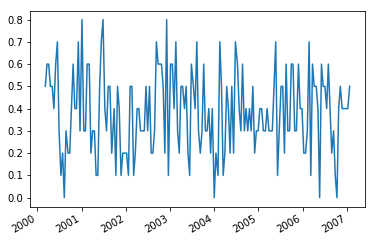

In [43]:
params['Accuracy'].plot()

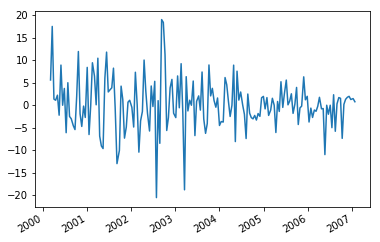

In [44]:
params['Sum of return'].plot()

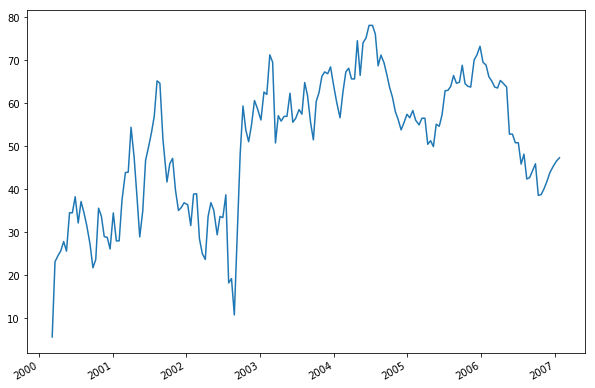

In [45]:
params['Sum of return'].cumsum().plot(figsize=(10,7))

#### Trades

In [46]:
all_trades = pd.concat([d['trades'] for d in test_params])

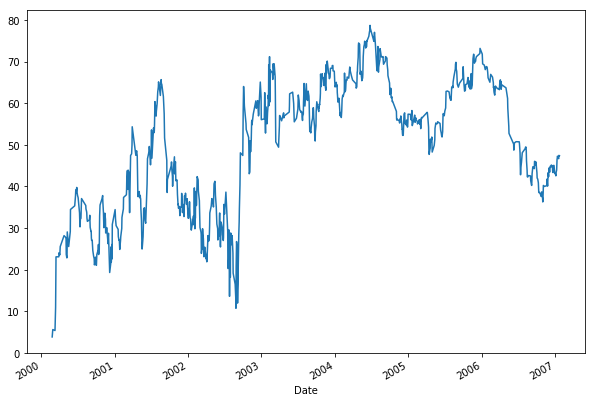

In [47]:
all_trades.cumsum().plot(figsize=(10,7))

#### Predictions

In [48]:
predictions = pd.concat([d['predictions'] for d in test_params])

In [49]:
predictions.value_counts()

Neutral    756
Neg        495
Pos        489
dtype: int64

In [50]:
predictions.to_csv(f'pred/prediction_{train_size}_{test_size}_{return_day}.csv', header=True)

### Feature importances

In [ ]:
assert 'features' in test_params[0]

In [ ]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [ ]:
features.idxmax(axis=1).value_counts()

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

In [ ]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')